In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML
HTML("""
<style>
.jp-Stdin-input {
    width: 80% !important;
    height : 1.5em !important;
    font-size : 1em;
    background : white;
    border:1px solid #cccccc;
}
</style>
""")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

In [27]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [28]:
vec = pickle.load(open('preprocess/MIMIC/vec.p', 'rb'))
vec.output_size = len(vec.label2idx)

freq = np.zeros((vec.vocab_size, ))
for x in vec.seqs['train'] :
    for w in x :
        freq[w] += 1
freq = freq / np.sum(freq)
vec.freq = freq

def map2words(sent) : 
    return [vec.idx2word[x] for x in sent]

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [29]:
import model.Attn_Mimic_Pert as M
Model = M.Model

In [6]:
X, Xt = vec.seqs['train'], vec.seqs['test']
y, yt = vec.label_one_hot['train'], vec.label_one_hot['test']

In [8]:
len_t = np.argsort([len(x) for x in Xt])
Xt = [Xt[i] for i in len_t]
yt = [yt[i] for i in len_t]

In [9]:
code_list = [vec.code_desc[vec.idx2label[i]] for i in range(len(vec.idx2label))]

In [10]:
from sklearn.metrics import roc_auc_score, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, vec.output_size, 32, dirname='mimic', hidden_size=128, pre_embed=vec.embeddings)
    for i in tqdm_notebook(range(10)) :
        loss = model.train(X, y, code_list)
        print(loss)
        o, he = model.evaluate(Xt, code_list)
        o = np.array(o)
        macro_auc = roc_auc_score(yt, o, average='macro')
        micro_auc = roc_auc_score(yt, o, average='micro')
        
        macro_f1 = f1_score(yt, np.where(o > 0.5, 1, 0), average='macro')
        micro_f1 = f1_score(yt, np.where(o > 0.5, 1, 0), average='micro')
        
        stmt = '%s, %s' % (i, loss)
        rep = 'Micro-AUC = %s, Macro-AUC = %s, Micro-F1 = %s, Macro-F1 = %s' %(micro_auc, macro_auc, micro_f1, macro_f1)
        print(rep)

        dirname = model.save_values(add_name=name)

        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [11]:
# train(name='TEST_embedding')

In [12]:
# for i in range(20) :
#     train(name='experiment_code_diff')

In [36]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, vec.output_size, 32, dirname='mimic', hidden_size=128, pre_embed=vec.embeddings)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [37]:
model = load_model('outputs/attn_sim_pert_mimic/SunSep2312:47:422018_TEST_embedding/')

Setting Embedding
Setting Embedding


In [38]:
# import os
# exps = os.listdir('outputs/attn_sim_pert_mimic/')
# exps = [e for e in exps if 'experiment' in e]

In [39]:
# model_normal_list = {}

# from sklearn.metrics import accuracy_score
# for e in exps :
#     dirname_normal = 'outputs/attn_sim_pert_mimic/'+ e
#     model = load_model(dirname_normal)
#     o, he = model.evaluate(Xt, code_list)
#     o = np.array(o)
#     macro_auc = roc_auc_score(yt, o, average='macro')
#     micro_auc = roc_auc_score(yt, o, average='micro')

#     macro_f1 = f1_score(yt, np.where(o > 0.5, 1, 0), average='macro')
#     micro_f1 = f1_score(yt, np.where(o > 0.5, 1, 0), average='micro')
#     rep = 'Micro-AUC = %s, Macro-AUC = %s, Micro-F1 = %s, Macro-F1 = %s' %(micro_auc, macro_auc, micro_f1, macro_f1)

#     print(rep)
#     model_normal_list[e] = model

In [41]:
o, he = model.evaluate(Xt[:500], code_list)

In [57]:
model.vec = vec
output = model.sampling(Xt[:500], code_list, sample_vocab=100)

Non Zero :  tensor(185, device='cuda:0', dtype=torch.uint8)


In [58]:
perts_attn, words_sampled, best_attn_idxs = output

In [60]:
best_icd9 = [np.argmax(x) for x in o]

In [63]:
perts_attn_med = [np.median(perts_attn[i], 1) for i in range(len(perts_attn))]

In [72]:
meds, attn_meds = [], []
for i in range(len(perts_attn)) :
    m = perts_attn_med[i]
    for j in range(10) :
        meds.append(m[best_attn_idxs[i][j], j])
        attn_meds.append(he[i][best_attn_idxs[i][j], best_icd9[i]])

In [51]:
perts_attn_med_best = np.array([perts_attn_med[i][best_attn_idxs[i]][0] for i in range(len(perts_attn))])

In [52]:
attn_med = np.array([he[i][best_attn_idxs[i], best_icd9[i]][0] for i in range(len(perts_attn))])

(0, 1)

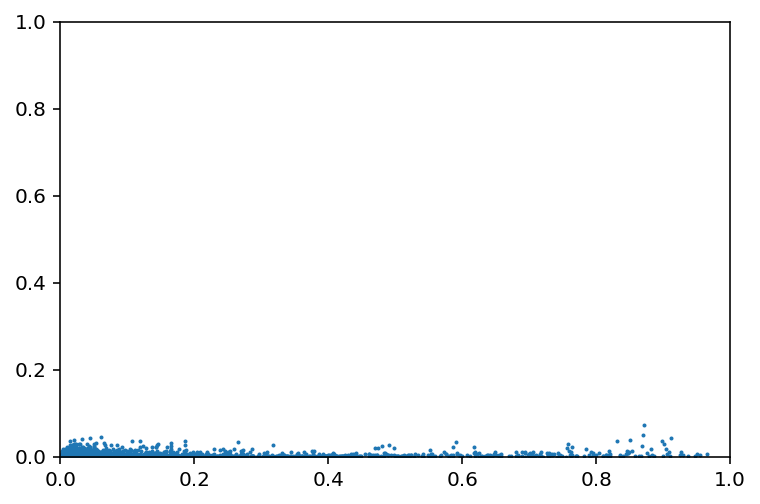

In [76]:
plt.scatter(attn_meds, meds, s=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [ ]:
from IPython.core.display import display, HTML
import re
def print_attn(sentence, attention) :
    l = []
    for w, a in zip(sentence, attention) :
        w = re.sub('&', '&amp;', w)
        w = re.sub('<', '&lt;', w)
        w = re.sub('>', '&gt;', w)
        
        l.append('<span style="background-color:hsl(360,100%,' + str((1-a) * 50 + 50) + '%)">' + w + ' </span>')
    display(HTML(''.join(l)))

In [ ]:
def plot_diff(sentence_1, idx, new_word, old_attn, new_attn) :
    L = len(sentence_1)
    print_attn(sentence_1, old_attn[:L])
    sentence_1 = [x for x in sentence_1]
    sentence_1[idx] = vec.idx2word[new_word]
    print("="*20)
    print_attn(sentence_1, new_attn[:L])

In [ ]:
n = 50
print(vec.label2desc[vec.idx2label[best_icd9[n]]])
plot_diff(map2words(Xt[n]), 
          best_attn_idxs[n][0], 
          int(words_sampled[n][0]), 
          he[n][:, best_icd9[n]], 
          perts_attn[n][:, 0])

In [ ]:
n = 20
p = o[n].argsort()[-3]
print(vec.label2desc[vec.idx2label[p]])

attn = he[n][:, p]
print_attn([vec.idx2word[x] for x in Xt[n]], attn)

In [ ]:
def calc_entropy(i) :
    h = he[i][:len(Xt[i])]
    p = o[i].argmax()
    a = h * np.log(np.clip(h, a_min=1e-8, a_max=None))
    a = -a.sum(0)
    return a[p], np.log(len(Xt[i])) 
entropy = [calc_entropy(i) for i in range(len(he))]

In [ ]:
x, y = zip(*entropy)
plt.scatter(x, y, s=1)

In [ ]:
y.shape